In [1]:
from filterpy.common import kinematic_kf
import numpy as np
from filterpy.kalman import IMMEstimator
import math
from filterpy.kalman import KalmanFilter
import pandas as pd

In [2]:
# import ipynb.fs.full.filter_base as imm_filter

In [3]:
test_df_path = "C:/Users/sakif/jupyter projects/thesis_test/modular test/Untitled Folder/HOTEL_data_prepared_normal3.csv"
# delta_t = 0.4

In [4]:
test_df = pd.read_csv(test_df_path, index_col=None)

In [5]:
test_df.head()

,frame_id,ped_no,pos_x,pos_y,vel_x,vel_y,rotation_angle,eta_group_x,eta_group_y,bound_x,...,n_w_y21,n_w_y22,n_w_y23,n_w_y24,n_w_y25,n_w_y26,n26_y,d_w_bound,n_w_bound_x,n_w_bound_y
0,1,1,1.398378,-5.743303,-0.327083,-1.680286,0.0,0.0,0.0,-0.957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.986398,0.280439,-0.959872
1,1,2,0.517796,-7.003832,0.097997,-1.629874,0.0,0.0,0.0,-0.719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.306127,0.082110,-0.996623
2,1,3,2.259814,-4.546597,-0.901111,1.187025,0.0,0.0,0.0,-0.957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.241694,0.532762,-0.846265
3,1,4,2.740179,-2.423851,0.053061,1.815625,0.0,0.0,0.0,-0.819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.175551,0.862899,-0.505377
4,1,5,-1.585502,0.927584,0.000000,0.000000,0.0,0.0,0.0,-0.857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.387165,-0.664178,0.747575


In [6]:
def state_transition_matrix(v, yaw, T):
    term13 = (v/yaw) * (-math.cos(yaw) + math.cos(T * yaw + yaw))
    term14 = (-math.sin(yaw) + math.sin(T * yaw + yaw))/yaw
    term15 = T * v * math.cos(T * yaw + yaw)/ yaw - v * (-math.sin(yaw) + math.sin(T * yaw + yaw)) / yaw **2
    term23 = (v/yaw) * (-math.sin(yaw) + math.sin(T * yaw + yaw))
    term24 = (math.cos(yaw) - math.cos(T * yaw + yaw)) / yaw
    term25 = T * v * math.sin(T * yaw + yaw)/ yaw - v * (math.cos(yaw) - math.cos(T * yaw + yaw)) / yaw **2
    state_transition_matrix = np.array([[1, 0, term13, term14, term15],
                                        [0, 1, term23, term24, term25],
                                        [0, 0, 1, 0, T],
                                        [0, 0, 0, 1, 0],
                                        [0, 0, 0, 0, 1]])
    return state_transition_matrix

def direction(current_state, destination_state):
    # atan2(b1−a1,b2−a2)
    directions1 = np.linalg.norm((np.array(destination_state) - np.array(current_state)))
    # dest_tempp = np.array(destination_state) - np.array(current_state)
    # temp_d = math.atan2(dest_tempp[0], dest_tempp[1])
    # directions1 = math.degrees(temp_d)
    # print(directions1)
    return directions1

In [27]:
dest_list = np.array(((0, -2.7109002e+05), (0, 1.5239712e+05), (5.7970002, -2.7628508), (-8.4644202, -3.2331944e+01),
                      (-8.315, -3.0036907e+01), (-8.16678, -2.7753721e+01), (-8.0191203e+00, -2.5482296e+01), 
                      (-7.8722121e+00, -2.3222540e+01), (-7.7260567e+00, -2.0974363e+01), (-7.5806484e+00, -1.8737678e+01),
                      (-7.4359814e+00, -1.6512396e+01), (-7.2920500e+00, -1.4298429e+01), (-7.1488487e+00, -1.2095693e+01), 
                      (-7.0063720e+00, -9.9041015), (-7.0063720, -9.9041015), (-6.8646142e+00, -7.7235703e+00), 
                      (-6.7235701e+00, -5.5540161e+00), (-6.5832343e+00, -3.3953560e+00), (-6.4436013e+00, -1.2475083e+00),
                      (-6.3046660e+00, 8.8960816e-01), (-6.1664232e+00, 3.0160735e+00), (-6.1664232e+00, 3.0160735e+00), 
                      (-6.0288676e+00, 5.1319672e+00), (-5.8919942e+00, 7.2373678e+00), (-5.7557978e+00, 9.3323533e+00), 
                      (-5.6202736e+00, 1.1417001e+01)))

In [28]:
dest_list.shape

(26, 2)

In [29]:
def imm_dest_filter2(input_xy_temp, dest_list):
    start = input_xy_temp[0]
    # zone1, zone2, zone3, zone4 = [-2, 5.8566027], [-6.5902743, 0.065724367], [-6.5553084, 1.1867515], [15.10717, 5.5659299]
    zone1, zone2, zone3, zone4, zone5 = dest_list[0], dest_list[1], dest_list[2], dest_list[3], dest_list[4]
    zone6, zone7, zone8, zone9, zone10 = dest_list[5], dest_list[6], dest_list[7], dest_list[8], dest_list[9]
    zone11, zone12, zone13, zone14, zone15 = dest_list[10], dest_list[11], dest_list[12], dest_list[13], dest_list[14]
    zone16, zone17, zone18, zone19, zone20 = dest_list[15], dest_list[16], dest_list[17], dest_list[18], dest_list[19]
    zone21, zone22, zone23, zone24, zone25 = dest_list[20], dest_list[21], dest_list[22], dest_list[23], dest_list[24]
    zone26 = dest_list[25]
    v, delta_t = 0.707, 0.4

    kf1 = KalmanFilter(dim_x=5, dim_z=2)
    kf2 = KalmanFilter(dim_x=5, dim_z=2)
    kf3 = KalmanFilter(dim_x=5, dim_z=2)
    kf4 = KalmanFilter(dim_x=5, dim_z=2)
    kf5 = KalmanFilter(dim_x=5, dim_z=2)
    kf6 = KalmanFilter(dim_x=5, dim_z=2)
    kf7 = KalmanFilter(dim_x=5, dim_z=2)
    kf8 = KalmanFilter(dim_x=5, dim_z=2)
    kf9 = KalmanFilter(dim_x=5, dim_z=2)
    kf10 = KalmanFilter(dim_x=5, dim_z=2)
    kf11 = KalmanFilter(dim_x=5, dim_z=2)
    kf12 = KalmanFilter(dim_x=5, dim_z=2)
    kf13 = KalmanFilter(dim_x=5, dim_z=2)
    kf14 = KalmanFilter(dim_x=5, dim_z=2)
    kf15 = KalmanFilter(dim_x=5, dim_z=2)
    kf16 = KalmanFilter(dim_x=5, dim_z=2)
    kf17 = KalmanFilter(dim_x=5, dim_z=2)
    kf18 = KalmanFilter(dim_x=5, dim_z=2)
    kf19 = KalmanFilter(dim_x=5, dim_z=2)
    kf20 = KalmanFilter(dim_x=5, dim_z=2)
    kf21 = KalmanFilter(dim_x=5, dim_z=2)
    kf22 = KalmanFilter(dim_x=5, dim_z=2)
    kf23 = KalmanFilter(dim_x=5, dim_z=2)
    kf24 = KalmanFilter(dim_x=5, dim_z=2)
    kf25 = KalmanFilter(dim_x=5, dim_z=2)
    kf26 = KalmanFilter(dim_x=5, dim_z=2)

    directions1, directions2, directions3 = direction(start, zone1), direction(start, zone2), direction(start, zone3)
    directions4, directions5, directions6 = direction(start, zone4), direction(start, zone5), direction(start, zone6)
    directions7, directions8, directions9 = direction(start, zone7), direction(start, zone8), direction(start, zone9)
    directions10, directions11, directions12 = direction(start, zone10), direction(start, zone11), direction(start, zone12)
    directions13, directions14, directions15 = direction(start, zone13), direction(start, zone14), direction(start, zone15)
    directions16, directions17, directions18 = direction(start, zone16), direction(start, zone17), direction(start, zone18)
    directions19, directions20, directions21 = direction(start, zone19), direction(start, zone20), direction(start, zone21)
    directions22, directions23, directions24 = direction(start, zone22), direction(start, zone23), direction(start, zone24)
    directions25, directions26 = direction(start, zone25), direction(start, zone26)

    state_transition1 = state_transition_matrix(v, directions1, delta_t)
    state_transition2 = state_transition_matrix(v, directions2, delta_t)
    state_transition3 = state_transition_matrix(v, directions3, delta_t)
    state_transition4 = state_transition_matrix(v, directions4, delta_t)
    state_transition5 = state_transition_matrix(v, directions5, delta_t)
    state_transition6 = state_transition_matrix(v, directions6, delta_t)
    state_transition7 = state_transition_matrix(v, directions7, delta_t)
    state_transition8 = state_transition_matrix(v, directions8, delta_t)
    state_transition9 = state_transition_matrix(v, directions9, delta_t)
    state_transition10 = state_transition_matrix(v, directions10, delta_t)
    state_transition11 = state_transition_matrix(v, directions11, delta_t)
    state_transition12 = state_transition_matrix(v, directions12, delta_t)
    state_transition13 = state_transition_matrix(v, directions13, delta_t)
    state_transition14 = state_transition_matrix(v, directions14, delta_t)
    state_transition15 = state_transition_matrix(v, directions15, delta_t)
    state_transition16 = state_transition_matrix(v, directions16, delta_t)
    state_transition17 = state_transition_matrix(v, directions17, delta_t)
    state_transition18 = state_transition_matrix(v, directions18, delta_t)
    state_transition19 = state_transition_matrix(v, directions19, delta_t)
    state_transition20 = state_transition_matrix(v, directions20, delta_t)
    state_transition21 = state_transition_matrix(v, directions21, delta_t)
    state_transition22 = state_transition_matrix(v, directions22, delta_t)
    state_transition23 = state_transition_matrix(v, directions23, delta_t)
    state_transition24 = state_transition_matrix(v, directions24, delta_t)
    state_transition25 = state_transition_matrix(v, directions25, delta_t)
    state_transition26 = state_transition_matrix(v, directions26, delta_t)

    kf1.F, kf2.F, kf3.F, kf4.F = state_transition1, state_transition2, state_transition3, state_transition4
    kf5.F = state_transition5
    kf6.F = state_transition6
    kf7.F = state_transition7
    kf8.F = state_transition8
    kf9.F = state_transition9
    kf10.F = state_transition10
    kf11.F = state_transition11
    kf12.F = state_transition12
    kf13.F = state_transition13
    kf14.F = state_transition14
    kf15.F = state_transition15
    kf16.F = state_transition16
    kf17.F = state_transition17
    kf18.F = state_transition18
    kf19.F = state_transition19
    kf20.F = state_transition20
    kf21.F = state_transition21
    kf22.F = state_transition22
    kf23.F = state_transition23
    kf24.F = state_transition24
    kf25.F = state_transition25
    kf26.F = state_transition26

    # define initial state [x, y, yaw, velocity, yaw*dt]
    kf1.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions1, v, directions1*delta_t])
    kf2.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions2, v, directions2*delta_t])
    kf3.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions3, v, directions3*delta_t])
    kf4.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions4, v, directions4*delta_t])
    kf5.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions5, v, directions5*delta_t])
    kf6.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions6, v, directions6*delta_t])
    kf7.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions7, v, directions7*delta_t])
    kf8.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions8, v, directions8*delta_t])
    kf9.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions9, v, directions9*delta_t])
    kf10.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions10, v, directions10*delta_t])
    kf11.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions11, v, directions11*delta_t])
    kf12.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions12, v, directions12*delta_t])
    kf13.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions13, v, directions13*delta_t])
    kf14.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions14, v, directions14*delta_t])
    kf15.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions15, v, directions15*delta_t])
    kf16.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions16, v, directions16*delta_t])
    kf17.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions17, v, directions17*delta_t])
    kf18.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions18, v, directions18*delta_t])
    kf19.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions19, v, directions19*delta_t])
    kf20.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions20, v, directions20*delta_t])
    kf21.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions21, v, directions21*delta_t])
    kf22.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions22, v, directions22*delta_t])
    kf23.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions23, v, directions23*delta_t])
    kf24.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions24, v, directions24*delta_t])
    kf25.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions25, v, directions25*delta_t])
    kf26.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions26, v, directions26*delta_t])

    sGPS, sCourse, sVelocity, sYaw = 0.5*8.8*delta_t**2, 0.1*delta_t, 8.8*delta_t, 1.0*delta_t
    temp_q = np.diag([sGPS**2, sGPS**2, sCourse**2, sVelocity**2, sYaw**2])
    # process noise
    kf1.Q, kf2.Q, kf3.Q, kf4.Q = temp_q, temp_q, temp_q, temp_q
    kf5.Q, kf6.Q, kf7.Q, kf8.Q = temp_q, temp_q, temp_q, temp_q
    kf9.Q, kf10.Q, kf11.Q, kf12.Q = temp_q, temp_q, temp_q, temp_q
    kf13.Q, kf14.Q, kf15.Q, kf16.Q = temp_q, temp_q, temp_q, temp_q
    kf17.Q, kf18.Q, kf19.Q, kf20.Q = temp_q, temp_q, temp_q, temp_q
    kf21.Q, kf22.Q, kf23.Q, kf24.Q = temp_q, temp_q, temp_q, temp_q
    kf25.Q, kf26.Q = temp_q, temp_q
    
    # measurement noise
    kf1.R, kf2.R, kf3.R, kf4.R = np.identity(2)*5, np.identity(2)*5, np.identity(2)*5, np.identity(2)*5
    kf5.R, kf6.R, kf7.R, kf8.R = np.identity(2)*5, np.identity(2)*5, np.identity(2)*5, np.identity(2)*5
    kf9.R, kf10.R, kf11.R, kf12.R = np.identity(2)*5, np.identity(2)*5, np.identity(2)*5, np.identity(2)*5
    kf13.R, kf14.R, kf15.R, kf16.R = np.identity(2)*5, np.identity(2)*5, np.identity(2)*5, np.identity(2)*5
    kf17.R, kf18.R, kf19.R, kf20.R = np.identity(2)*5, np.identity(2)*5, np.identity(2)*5, np.identity(2)*5
    kf21.R, kf22.R, kf23.R, kf24.R = np.identity(2)*5, np.identity(2)*5, np.identity(2)*5, np.identity(2)*5
    kf25.R, kf26.R = np.identity(2)*5, np.identity(2)*5
    # Define the covariance matrix.
    # Here I take advantage of the fact that P already contains np.eye(dim_x), and just multiply by the uncertainty:
    kf1.P *= 10; kf2.P *= 10; kf3.P *= 10; kf4.P *= 10
    kf5.P *= 10; kf6.P *= 10; kf7.P *= 10; kf8.P *= 10
    kf9.P *= 10; kf10.P *= 10; kf11.P *= 10; kf12.P *= 10
    kf13.P *= 10; kf14.P *= 10; kf15.P *= 10; kf16.P *= 10
    kf17.P *= 10; kf18.P *= 10; kf19.P *= 10; kf20.P *= 10
    kf21.P *= 10; kf22.P *= 10; kf23.P *= 10; kf24.P *= 10
    kf25.P *= 10; kf26.P *= 10
        

    # define measurement function
    kf1.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf2.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf3.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf4.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf5.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf6.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf7.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf8.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf9.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf10.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf11.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf12.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf13.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf14.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf15.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf16.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf17.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf18.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf19.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf20.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf21.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf22.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf23.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf24.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf25.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf26.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])

    filters = [kf1, kf2, kf3, kf4, kf5, kf6, kf7, kf8, kf9, kf10, kf11, kf12, kf13, kf14, kf15, kf16, kf17, 
               kf18, kf19, kf20, kf21, kf22, kf23, kf24, kf25, kf26]

    mu = [0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846,
          0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846, 0.03846,
          0.03846, 0.03846] # each filter is equally likely at the start
    
    temp_arrr = np.full((26, 26), 0.01)
    np.fill_diagonal(temp_arrr, 0.75)

    trans = temp_arrr
    # M[i,j] is the probability of switching from filter j to filter i.

    imm = IMMEstimator(filters, mu, trans)
    for i in range(len(input_xy_temp)):
        z = input_xy_temp[i]
        imm.predict()
        imm.update(z)
    chosen_filter = np.argmax(imm.mu)
    estimated_destination = dest_list[chosen_filter]
    # print("Highest probability: ", np.max(imm.mu))
    return estimated_destination

In [46]:
def imm_dest_filter(input_xy_temp, dest_list):
    start = input_xy_temp[0]
    # zone1, zone2, zone3, zone4 = [-2, 5.8566027], [-6.5902743, 0.065724367], [-6.5553084, 1.1867515], [15.10717, 5.5659299]
    zone1, zone2, zone3, zone4 = dest_list[0], dest_list[1], dest_list[2], dest_list[3]
    v, delta_t = 0.707, 0.4

    kf1 = KalmanFilter(dim_x=5, dim_z=2)
    kf2 = KalmanFilter(dim_x=5, dim_z=2)
    kf3 = KalmanFilter(dim_x=5, dim_z=2)
    kf4 = KalmanFilter(dim_x=5, dim_z=2)

    directions1, directions2, directions3 = direction(start, zone1), direction(start, zone2), direction(start, zone3)
    directions4 = direction(start, zone4)

    state_transition1 = state_transition_matrix(v, directions1, delta_t)
    state_transition2 = state_transition_matrix(v, directions2, delta_t)
    state_transition3 = state_transition_matrix(v, directions3, delta_t)
    state_transition4 = state_transition_matrix(v, directions4, delta_t)

    kf1.F, kf2.F, kf3.F, kf4.F = state_transition1, state_transition2, state_transition3, state_transition4

    # define initial state [x, y, yaw, velocity, yaw*dt]
    kf1.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions1, v, directions1*delta_t])
    kf2.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions2, v, directions2*delta_t])
    kf3.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions3, v, directions3*delta_t])
    kf4.x = np.array([input_xy_temp[0, 0], input_xy_temp[0, 1], directions4, v, directions4*delta_t])

    sGPS, sCourse, sVelocity, sYaw = 0.5*8.8*delta_t**2, 0.1*delta_t, 8.8*delta_t, 1.0*delta_t
    temp_q = np.diag([sGPS**2, sGPS**2, sCourse**2, sVelocity**2, sYaw**2])
    # process noise
    kf1.Q, kf2.Q, kf3.Q, kf4.Q = temp_q, temp_q, temp_q, temp_q
    # measurement noise
    kf1.R, kf2.R, kf3.R, kf4.R = np.identity(2)*5, np.identity(2)*5, np.identity(2)*5, np.identity(2)*5
    # Define the covariance matrix.
    # Here I take advantage of the fact that P already contains np.eye(dim_x), and just multiply by the uncertainty:
    kf1.P *= 10; kf2.P *= 10; kf3.P *= 10; kf4.P *= 10

    # define measurement function
    kf1.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf2.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf3.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])
    kf4.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0]])

    filters = [kf1, kf2, kf3, kf4]

    mu = [0.25, 0.25, 0.25, 0.25] # each filter is equally likely at the start

    trans = np.array([[0.90, 0.033, 0.033, 0.033], 
                      [0.033, 0.90, 0.033, 0.033], 
                      [0.033, 0.033, 0.90, 0.033],
                      [0.033, 0.033, 0.033, 0.90]
                     ]) 
    # M[i,j] is the probability of switching from filter j to filter i.

    imm = IMMEstimator(filters, mu, trans)
    for i in range(len(input_xy_temp)):
        z = input_xy_temp[i]
        imm.predict()
        imm.update(z)
    chosen_filter = np.argmax(imm.mu)
    estimated_destination = dest_list[chosen_filter]
    # print("Highest probability: ", np.max(imm.mu))
    return estimated_destination

In [30]:
temp_arrr = np.full((26, 26), 0.01)
np.fill_diagonal(temp_arrr, 0.75)
# temp_arrr

In [63]:
center_points = np.array([[ 1.32669557, -8.29820966], [ 2.1508649 ,  2.71662071], [ 3.14254298, -2.47933621], 
                          [-1.05808014, -1.08395512]])

In [64]:
unique_peds = np.unique(test_df['ped_no'])
dest_list = center_points
estimated_dest_list = []
for n in range(len(unique_peds)):
    test_df_indiv3 = test_df.loc[test_df['ped_no'] == unique_peds[n]]
    input_xy_temp3 = np.array(test_df_indiv3[['pos_x', 'pos_y']])
    estimated_dest_temp = imm_dest_filter(input_xy_temp3, dest_list)
    estimated_dest_list.append(estimated_dest_temp)
    # dest_temp = input_xy_temp2[-1]
    # dest_all.append(dest_temp)
#dest_all = np.array(dest_all)
estimated_dest_list = np.array(estimated_dest_list)
len(estimated_dest_list)
# estimated_dest_list

389

In [65]:
actual_dest_list = []
for n in range(len(unique_peds)):
    test_df_indiv3 = test_df.loc[test_df['ped_no'] == unique_peds[n]]
    input_xy_temp3 = np.array(test_df_indiv3[['pos_x', 'pos_y']])
    temp_n = np.argmin(np.linalg.norm((dest_list - input_xy_temp3[-1]), axis=1))
    temp_n2 = dest_list[temp_n]
    actual_dest_list.append(temp_n2)
actual_dest_list = np.array(actual_dest_list)
len(actual_dest_list)
# actual_dest_list

389

In [67]:
np.count_nonzero(actual_dest_list == estimated_dest_list)

378

In [35]:
from matplotlib import pyplot as plt

In [41]:
dest_list = np.array(((0, -2.7109002), (0, 1.5239712), (5.7970002, -2.7628508), (-8.4644202, -3.2331944),
                      (-8.315, -3.0036907), (-8.16678, -2.7753721e+01), (-8.0191203e+00, -2.5482296e+01), 
                      (-7.8722121e+00, -2.3222540e+01), (-7.7260567e+00, -2.0974363), (-7.5806484e+00, -1.8737678e+01),
                      (-7.4359814e+00, -1.6512396e+01), (-7.2920500e+00, -1.4298429), (-7.1488487e+00, -1.2095693e+01), 
                      (-7.0063720e+00, -9.9041015), (-7.0063720, -9.9041015), (-6.8646142e+00, -7.7235703e+00), 
                      (-6.7235701e+00, -5.5540161e+00), (-6.5832343e+00, -3.3953560e+00), (-6.4436013e+00, -1.2475083e+00),
                      (-6.3046660e+00, 8.8960816e-01), (-6.1664232e+00, 3.0160735e+00), (-6.1664232e+00, 3.0160735e+00), 
                      (-6.0288676e+00, 5.1319672e+00), (-5.8919942e+00, 7.2373678e+00), (-5.7557978e+00, 9.3323533e+00), 
                      (-5.6202736e+00, 1.1417001e+01)))

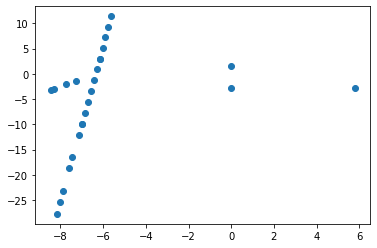

In [42]:
plt.scatter(dest_list[:, 0], dest_list[:, 1])

In [53]:
unique_peds = np.unique(test_df['ped_no'])
dest_all = []
for n in range(len(unique_peds)):
    test_df_indiv2 = test_df.loc[test_df['ped_no'] == unique_peds[n]]
    input_xy_temp2 = np.array(test_df_indiv2[['pos_x', 'pos_y']])
    dest_temp = input_xy_temp2[-1]
    dest_all.append(dest_temp)
dest_all = np.array(dest_all)
# dest_all

In [60]:
# actual_dest_list

In [43]:
from sklearn.cluster import KMeans

In [56]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(dest_all)
center_points = kmeans.cluster_centers_
center_points

array([[ 1.32669557, -8.29820966],
       [ 2.1508649 ,  2.71662071],
       [ 3.14254298, -2.47933621],
       [-1.05808014, -1.08395512]])

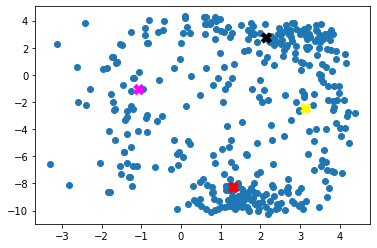

In [57]:
plt.scatter(dest_all[:, 0], dest_all[:, 1])
# plt.xlim(-10, 17)
# plt.ylim(-10, 17)
plt.scatter(center_points[:, 0], center_points[:, 1], c=["red", "black", "yellow", "magenta"], marker="X", s=100)

In [34]:
np.count_nonzero(actual_dest_list[:, 1] == estimated_dest_list[:, 1])

0

In [68]:
df_dest = pd.DataFrame(data=estimated_dest_list, index= unique_peds)
df_dest = df_dest.rename(columns={0: "dest_x", 1: "dest_y"})

In [69]:
df_dest

,dest_x,dest_y
1,2.150865,2.716621
2,2.150865,2.716621
3,2.150865,2.716621
4,1.326696,-8.298210
5,1.326696,-8.298210
...,...,...
416,1.326696,-8.298210
417,1.326696,-8.298210
418,-1.058080,-1.083955
419,2.150865,2.716621


In [70]:
df_dest.to_csv("hotel_estimated_dests1.csv", columns=["dest_x", "dest_y"])